# Particle MCMC model for COVID-19 in Mexico

This notebook contains all of the Python code needed to use Particle Marginal Markov Chain Monte Carlo to explore the parameter space of our diffusion driven model and estimate the trajectories of the hidden states

In [3086]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln

In [651]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.head()

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0


In [652]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.1% of Population: ', np.round(0.001*N).astype(int))


Total Population:  126014024
0.1% of Population:  126014


Below we create two functions to draw from our prior distributions for initial value conditions and model parameters

In [3894]:
# Initial Value Conditions Prior
def set_IVC(N, rho, nu, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = np.round(stats.uniform(0, np.round(0.001 * N).astype(int)).rvs(num_particles))
    U = np.round(stats.uniform(0, np.round(E).astype(int)).rvs(num_particles))
    O = np.zeros(num_particles)
    E -=  U 
    S = N - E - U 
    
    beta = stats.uniform(0,1).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    psi_d = stats.gamma(50,scale=100).rvs()
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]
    

We begin by defining the SEUORDS model and understanding if the model will be able to produce results similar to those seen during the COVID-19 pandemic in Mexico

In [3895]:
T = 100
m = 3
h = 1/(m+1)
num_steps = int(T / h)
num_particles=100

# Initialize arrays to store results
time = np.linspace(0, T, num_steps)
X = np.zeros([8,num_particles,num_steps])
Z1 = np.zeros([num_particles, num_steps])
Z2 = np.zeros([num_particles, num_steps])

# Set initial conditions
alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d = set_param_priors()
X[:,:,0] = set_IVC(N, rho, nu, num_particles)
Z1[:,0] = np.log(X[6,:,0]+ 1e-10)
Z2[:,0] = np.log(X[7,:,0]+ 1e-10)

# Simulate the SIR model with stochastic beta using Euler-Maruyama method
for t in range(1, num_steps):
    # Sample Brownian increment
    dB1 = stats.norm(0,1).rvs(num_particles)
    dB2 = stats.norm(0,1).rvs(num_particles)
    # Update Z using Euler-Maruyama method
    Z1[:,t] = Z1[:,t-1] + sigma_b * np.sqrt(h) * dB1 
    Z2[:,t] = Z2[:,t-1] + sigma_m * np.sqrt(h) * dB2
    # Update time-varying parameter values
    X[6,:,t] = 1 / (1 + np.exp(-Z1[:, t])) # np.exp(Z1[:,t]) #update beta(t)
    X[7,:,t] = 1 / (1 + np.exp(-Z2[:, t])) # np.exp(Z2[:,t]) #update mu(t)   
    
    #Update SEUORDS model
    X[0,:,t] =  X[0,:,t-1] + (-X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N + alpha*X[4,:,t-1])*h   # S-Susceptibles
    X[1,:,t] =  X[1,:,t-1] + (X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N - nu*X[1,:,t-1])*h       # E-Exposed
    X[2,:,t] =  X[2,:,t-1] + (rho*nu*X[1,:,t-1] - gamma*X[2,:,t-1])*h                                  # U-Unobserved
    X[3,:,t] =  X[3,:,t-1] + ((1-rho)*nu*X[1,:,t-1] - gamma*X[3,:,t-1] - X[7,:,t]*X[3,:,t-1])*h        # O-Observed
    X[4,:,t] =  X[4,:,t-1] + (gamma*(X[2,:,t-1] + X[3,:,t-1]) - alpha*X[4,:,t-1])*h                    # R-Recovered
    X[5,:,t] =  X[5,:,t-1] + (X[7,:,t]*X[3,:,t-1])*h                                                   # D-Death

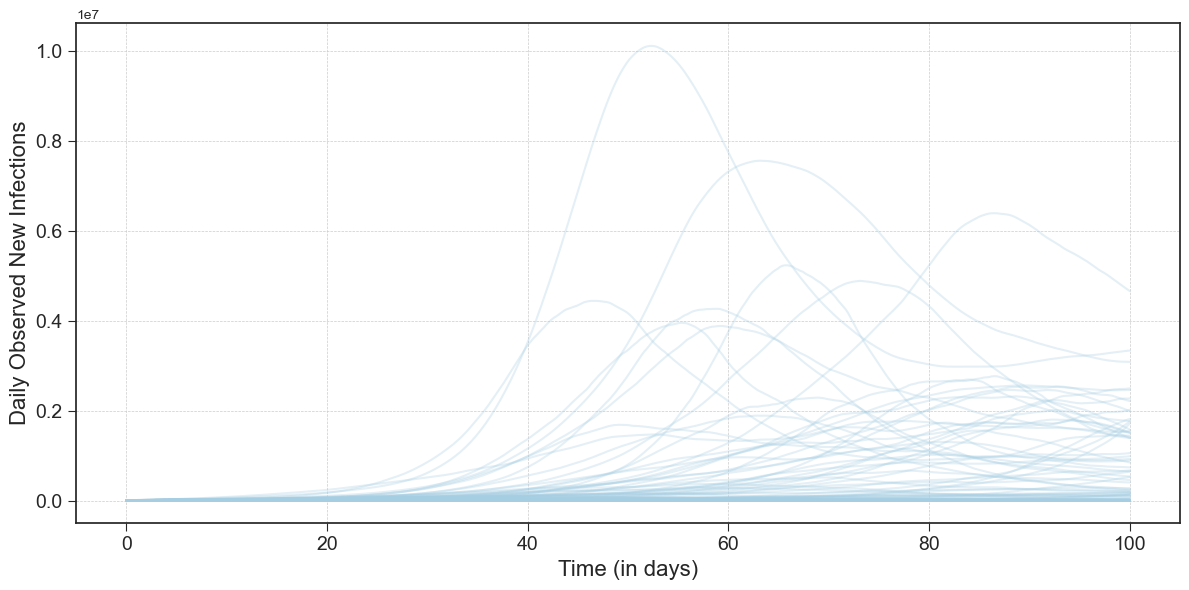

In [3899]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(num_particles):
    plt.plot(time,X[3, p, :], color=colors[0], alpha=0.3)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in days)', fontsize=16)
plt.ylabel('Daily Observed New Infections', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

We now create a function to run our diffusion-driven epidemic model so that it can compute the hidden state transitions between observations

In [3900]:
def BM_SEUORDS(X_in, params, num_particles, m):  
    h = 1 / (m + 1) 
    num_steps = 7*(m+1) + 1 #Simulate m events per week and the first event of the following week

    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles, num_steps])
    Z1 = np.zeros([num_particles, num_steps])
    Z2 = np.zeros([num_particles, num_steps])
    new_observed = np.zeros([num_particles, num_steps])
    new_deaths = np.zeros([num_particles, num_steps])

    # Set initial conditions
    alpha, rho, nu, gamma, sigma_b, sigma_m, _, _ = params
    X[:, :, 0] = X_in
    Z1[:, 0] = np.log(X_in[6, :] + 1e-10)
    Z2[:, 0] = np.log(X_in[7, :] + 1e-10)
    new_observed = np.zeros(num_particles)
    new_deaths = np.zeros(num_particles)

    # Simulate the SIR model with stochastic beta using Euler-Maruyama method
    for t in range(1, num_steps):
        # Sample Brownian increment
        dB1 = stats.norm(0, np.sqrt(h)).rvs(num_particles)
        dB2 = stats.norm(0, np.sqrt(h)).rvs(num_particles)
        
        # Update Z using Euler-Maruyama method
        Z1[:, t] = Z1[:, t - 1] + sigma_b * dB1
        Z2[:, t] = Z2[:, t - 1] + sigma_m * dB2
        
        # Update time-varying parameter values
        X[6, :, t] = 1 / (1 + np.exp(-Z1[:, t]))  # Update beta(t)    # np.exp(Z1[:,t]) 
        X[7, :, t] = 1 / (1 + np.exp(-Z2[:, t]))  # Update mu(t)      # np.exp(Z2[:,t]) 
        
        # Update SEUORDS model
        X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
        X[1, :, t] = X[1, :, t - 1] + (X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
        X[2, :, t] = X[2, :, t - 1] + (rho * nu * X[1, :, t - 1] - gamma * X[2, :, t - 1]) * h                                                # U-Unobserved
        X[3, :, t] = X[3, :, t - 1] + ((1 - rho) * nu * X[1, :, t - 1] - gamma * X[3, :, t - 1] - X[7, :, t] * X[3, :, t - 1]) * h            # O-Observed
        X[4, :, t] = X[4, :, t - 1] + (gamma * (X[2, :, t - 1] + X[3, :, t - 1]) - alpha * X[4, :, t - 1]) * h                                # R-Recovered
        X[5, :, t] = X[5, :, t - 1] + (X[7, :, t] * X[3, :, t - 1]) * h                                                                       # D-Death
        
        new_observed += ((1 - rho) * nu * X[1, :, t - 1]) * h
        new_deaths += (X[7, :, t] * X[3, :, t - 1]) * h   
    
    return X, new_observed, new_deaths


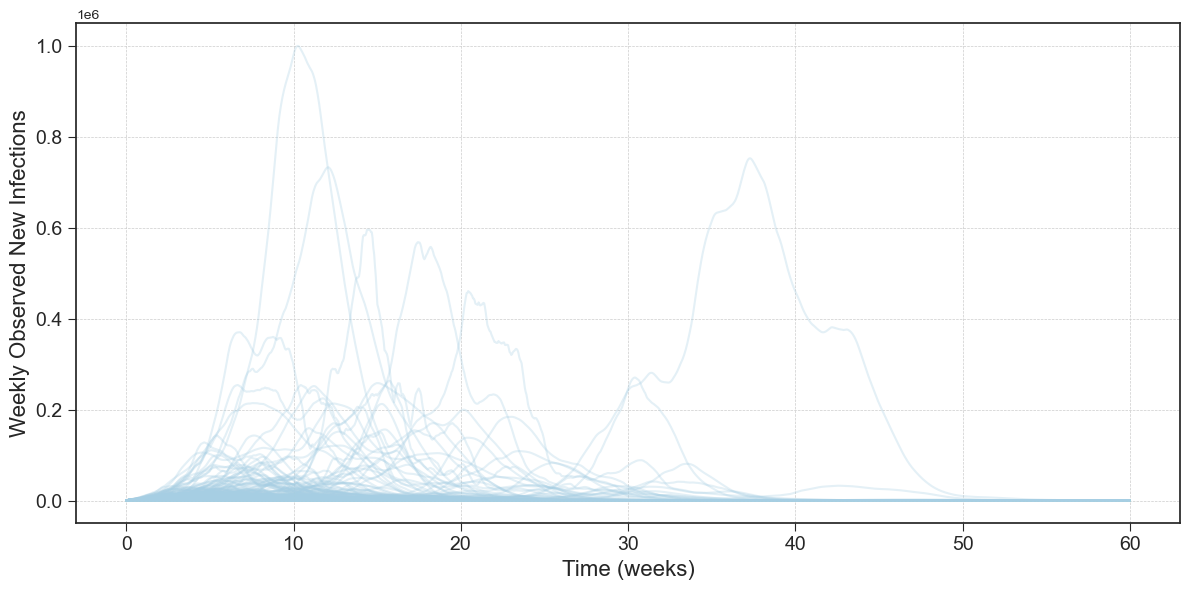

In [3901]:
T = 60
m = 2
num_particles = 500
num_steps_per_week = 7 * (m + 1) 
total_steps = T * num_steps_per_week

# Set initial conditions
params = set_param_priors()
initial_states = set_IVC(N, params[1], params[2], num_particles)
states = np.zeros([initial_states.shape[0], num_particles, total_steps + 1])  # Extra step to use last point from past week as initial value condition
states[:, :, 0] = initial_states
aggregates = np.zeros([2, num_particles, total_steps])
start_idx = 0

# Run the model with weekly aggregation
for t in range(T):
    end_idx = start_idx + num_steps_per_week    
    weekly_results, new_observed, new_deaths = BM_SEUORDS(states[:, :, start_idx], params, num_particles, m)
    states[:, :, start_idx:end_idx + 1] = weekly_results
    aggregates[:,:,t] = np.stack((new_observed, new_deaths), axis=0)
    start_idx = end_idx 

# Plot the simulation for each particle
time = np.linspace(0, T, total_steps)  # Include the extra final point for plotting

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(num_particles):
    plt.plot(time, states[3, p, :-1], color=colors[0], alpha=0.3)
    
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Weekly Observed New Infections', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Having succesfully implemented the weekly version of our model we can proceed to define our likelihood functions and test-run a simple bootstrap particle filter

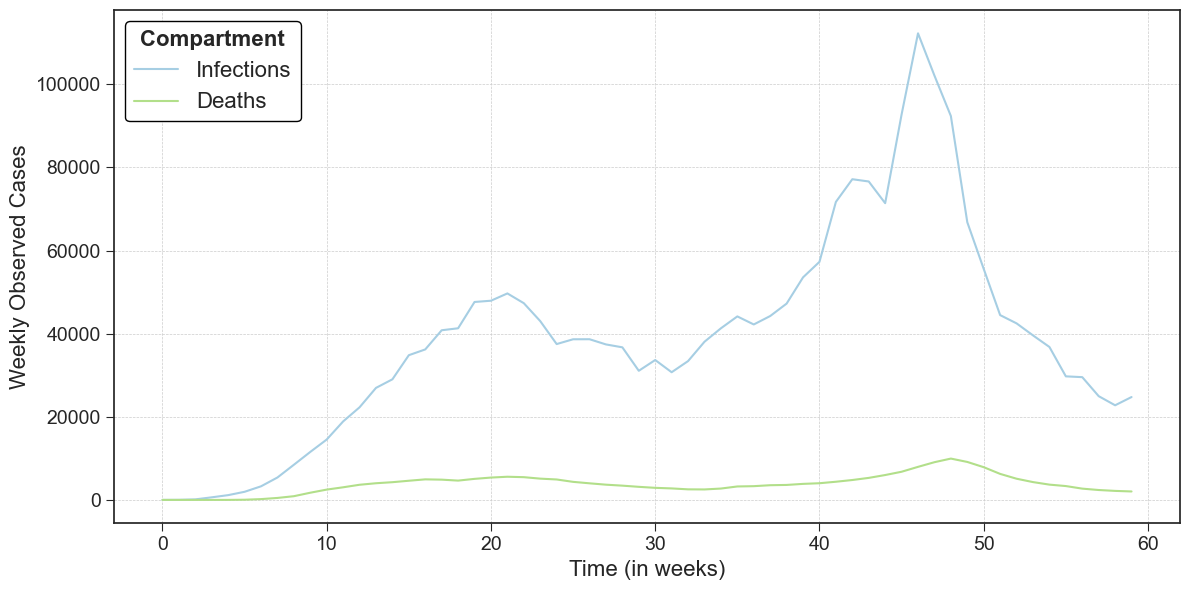

In [3902]:
# Define subset of data to run the algorithm 
T = 60
YO = weekly_covid_df['confirmed_cases'].values[:T]
YD = weekly_covid_df['confirmed_deaths'].values[:T]

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(np.arange(YO.shape[0]), YO, color=colors[0], label='Infections')
plt.plot(np.arange(YD.shape[0]), YD, color=colors[2], label='Deaths')


plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [3903]:
# Define Systematic Resampling Function
def systematic_resampling(norm_weights):
    n = norm_weights.shape[0]
    
    # Step 1: generate positions
    r = stats.uniform(0,1).rvs() #starting position
    positions =  (np.arange(n) + r )/n

    # Step 2: generate ancestry matrix
    resample_indices = np.searchsorted(np.cumsum(norm_weights), positions)
    
    return resample_indices

In [3954]:
# Create NB log-likelihood function
def NB_log_likelihood(y, mu, psi):
    # Add a small positive constant to avoid numerical instability
    mu = np.maximum(mu, 1e-10)
    psi = np.maximum(psi, 1e-10)
    aux = np.maximum(mu + psi, 1e-10)
    
    return gammaln(y + psi) - gammaln(y+1) - gammaln(psi) + y * np.log(mu) - y * np.log(aux) + psi * np.log(psi) - psi * np.log(aux)

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_69169/3226007242.py:47: RuntimeWarning: invalid value encountered in divide
  norm_weights[:,t] = weights[:,t]/weights_sum


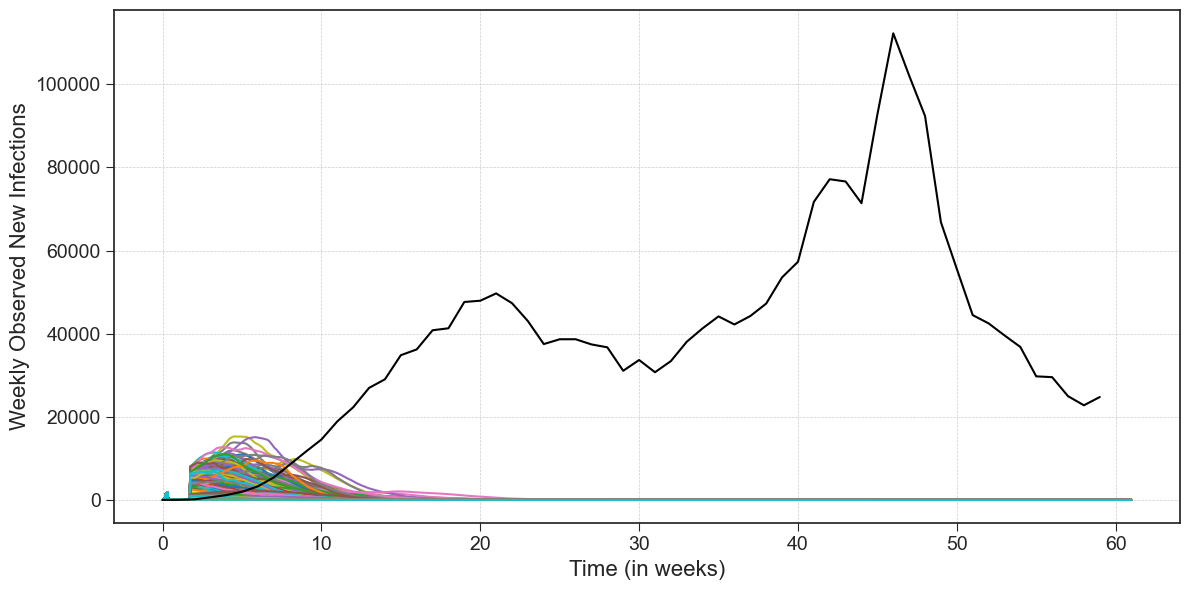

In [3590]:
m = 2
num_particles = 100
num_steps_per_week = 7 * (m + 1) 
total_steps = T * num_steps_per_week

params = set_param_priors()
initial_states = set_IVC(N, params[1], params[2], num_particles)





###############
h = 1/5
num_particles = 100
num_steps_per_week = int(7 / h)
params = set_param_priors()
initial_states = set_IVC(N, params[1], params[2], num_particles)

# Correct total_steps calculation
total_steps = T * num_steps_per_week 

# Initialize variables for storage
particles = np.zeros([initial_states.shape[0], num_particles, total_steps+1])
aggregates = np.zeros([2, num_particles, total_steps+1])
ancestry_matrix = np.zeros([num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)

#At time t=1 (in python idx = 0)
particles[:, :, 0] = initial_states
ancestry_matrix[:,0] = np.arange(num_particles)

incremental_weights = NB_likelihood(YO[0], particles[3,:,0], params[6]) * NB_likelihood(YD[0], particles[5,:,0], params[7])
weights[:,0] = incremental_weights
weights_sum = np.sum(weights[:,0])
norm_weights[:,0] = weights[:,0]/weights_sum
ESS[0] = 1/np.sum(norm_weights[:,0]**2)
resample_indices  = systematic_resampling(norm_weights[:,0])
ancestry_matrix[:,0] = resample_indices
particles[:, :, 0] = particles[:, resample_indices, 0]

# Run the model with weekly aggregation
for t in range(1,T):
    if t == 1:
        start_idx = 0
    else:
        start_idx = end_idx
    
    end_idx = start_idx + num_steps_per_week
        
    weekly_results, new_observed, new_deaths = BM_SEUORDS(particles[:, :, start_idx], params, num_particles, h)
    particles[:, :, start_idx:end_idx+1] = weekly_results
    aggregates[:,:,start_idx:end_idx+1] = np.stack((new_observed, new_deaths), axis=0)
    
    incremental_weights = NB_likelihood(YO[t], np.sum(new_observed, axis=1), params[6]) * NB_likelihood(YD[t], np.sum(new_deaths, axis=1), params[7])
    weights[:,t] = incremental_weights
    weights_sum = np.sum(weights[:,t])
    norm_weights[:,t] = weights[:,t]/weights_sum
    ESS[t] = 1/np.sum(norm_weights[:,t]**2)
    
    resample_indices  = systematic_resampling(norm_weights[:,t])
    ancestry_matrix[:,t] = resample_indices
    particles[:, :, t] = particles[:, resample_indices, t]
    
#Plot the simulation for each particle p
total_steps = particles.shape[2]
time = np.linspace(0, T+1, total_steps) 

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(num_particles):
    plt.plot(time,particles[3,p,:])
    plt.xlabel('Time (weeks)')

plt.plot(YO, color='black')
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed New Infections', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()